# Intro to Rectified Linear Unit

*Based on this blog: [A Gentle Introduction to the Rectified Linear Unit (ReLU)](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)*

*Also includes experiments based on the [03_penguin_neural_classifier](/notebooks/03_penguin_neural_classifier.ipynb) notebook.* 

ReLU is a very simple function defined as $ relu(x) = max(x, 0) $. It is often used as an activation function for neural networks. 

## BUT WHY?

We are going to explore this topic.

<br/>
<details>
    <summary><b>Spoiler</b></summary>
  The question turned out to be surprisingly important. It is related to the roots of deep-learning field (which sounds insane to me). Investigating this topic is very useful for understanding evolution of deep-learning techniques.
</details>

## Plot

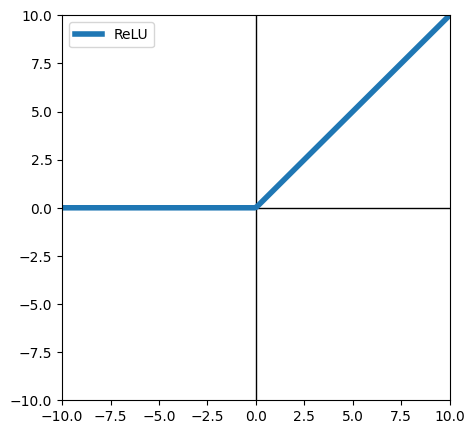

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt

x = tf.linspace(-10, 10, 200)

plt.figure(figsize=(5, 5))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)
plt.plot(x, tf.nn.relu(x), label="ReLU", linewidth=4)
plt.ylim((-10, 10))
plt.xlim((-10, 10))
plt.legend()
plt.show()

# Experiment

Firts let's experiment with penguin classification problem. Lets parametrize the problem by the activation function.

## Data

In [19]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)
data_test, data_train = dataset
test_batches = data_test.batch(32)
train_batches = data_train.batch(32)

**NOTE** on the `split=['train[:20%]', 'train[20%:]'` argument. 

This is a [Slicing API](https://www.tensorflow.org/datasets/splits) notation. This is the same as Python slicing notation `seq[:n]` with the only difference that besides absolute values, `n` could be a percentage of the entire collection e.g. `train[20%:]`.

## Define Parametrized Experiment

In [76]:
from dataclasses import dataclass, field
from typing import Sequence

def preview(func, name):
    x = tf.linspace(-10, 10, 200)
    plt.figure(figsize=(5, 5))
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(0, color="black", linewidth=1)
    plt.plot(x, func(x), label=name, linewidth=4)
    plt.ylim((-10, 10))
    plt.xlim((-10, 10))
    plt.legend()
    plt.show()

def make_model(activation, inner_layers=1, size=10):
    layers = [tf.keras.layers.Dense(size, activation=activation, input_shape=(4,))]
    for _ in range(inner_layers):
        layers.append(tf.keras.layers.Dense(size, activation=activation))
    layers.append(tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax))
    return tf.keras.Sequential(layers)

def calc_gradient(model, inputs, outputs, loss_func):
    with tf.GradientTape() as tape:
        loss_value = loss_func(
            y_true=outputs,
            y_pred=model(inputs),
        )
    gradient = tape.gradient(loss_value, model.trainable_variables)
    return loss_value, gradient

@dataclass
class LearningHistory:
    loss: Sequence[float] = field(default_factory=list)
    accuracy: Sequence[float] = field(default_factory=list)
        
    def draw(self):
        epochs = len(self.loss)
        plt.plot(range(epochs), self.loss, label="Loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(epochs), self.accuracy, label="Accuracy")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.legend()
        plt.show()
        
def train(model, train_batches, loss, optimizer, epochs=200) -> LearningHistory:
    history = LearningHistory()
    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        for inputs, outputs in train_batches:
            l, gradients = calc_gradient(model, inputs, outputs, loss)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            epoch_loss_avg.update_state(l)
            epoch_accuracy.update_state(outputs, model(inputs, training=True))
        history.loss.append(epoch_loss_avg.result())
        history.accuracy.append(epoch_accuracy.result())
    return history

@dataclass
class Result:
    history: LearningHistory
    accuracy: float
        
def evaluate(model, test_batches) -> float:
    accuracy = tf.keras.metrics.Accuracy()
    for inputs, outputs in test_batches:
        prediction = tf.math.argmax(model(inputs), axis=1, output_type=tf.int64)
        accuracy(prediction, outputs)
    return accuracy.result().numpy()

def experiment(activation, train_batches, test_batches, epochs=300, loss=None, optimizer=None, size=10, inner_layers=1) -> Result:
    loss = loss or tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = optimizer or tf.keras.optimizers.SGD(learning_rate=0.01)
    model = make_model(activation, inner_layers=inner_layers, size=size)
    history = train(
        model=model,
        train_batches=train_batches,
        loss=loss, 
        optimizer=optimizer,
        epochs=epochs,
    )
    accuracy = evaluate(model, test_batches)
    return Result(history, accuracy)


## ReLU

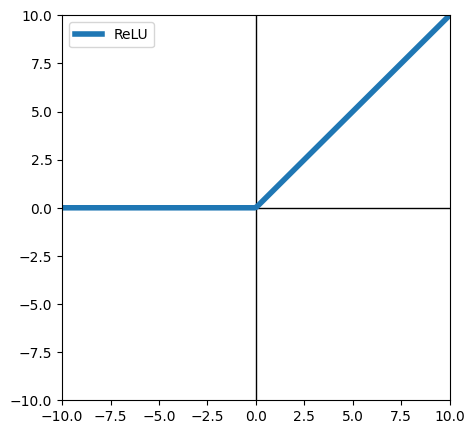

In [79]:
preview(tf.nn.relu, "ReLU")

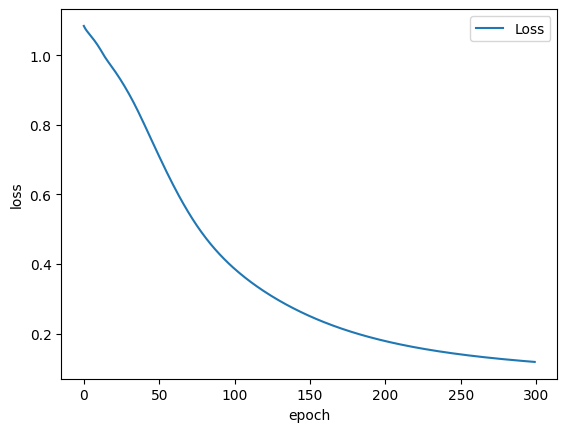

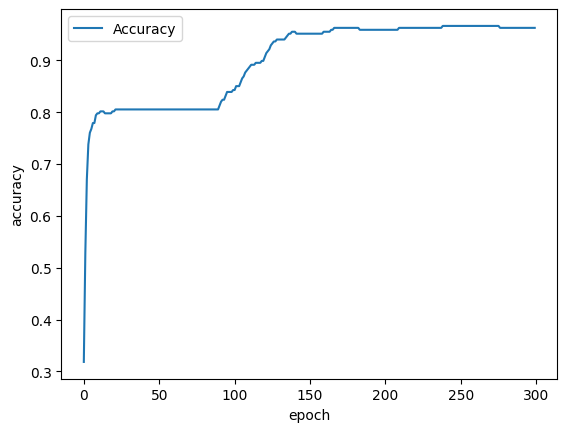

Accuracy: 0.97


In [78]:
result = experiment(tf.nn.relu, train_batches, test_batches)
result.history.draw()
print(f"Accuracy: {result.accuracy:0.2f}")

## tanh

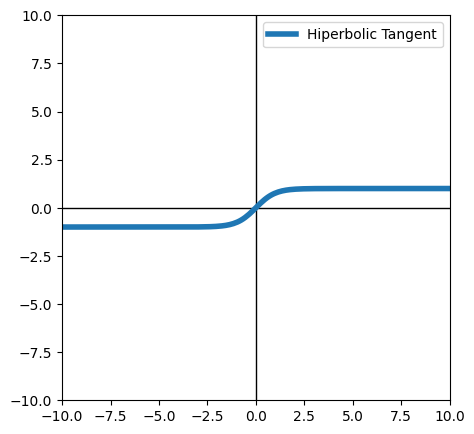

In [80]:
preview(tf.math.tanh, "Hiperbolic Tangent")

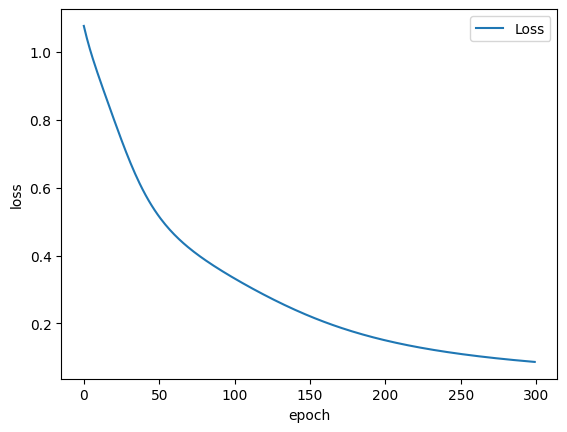

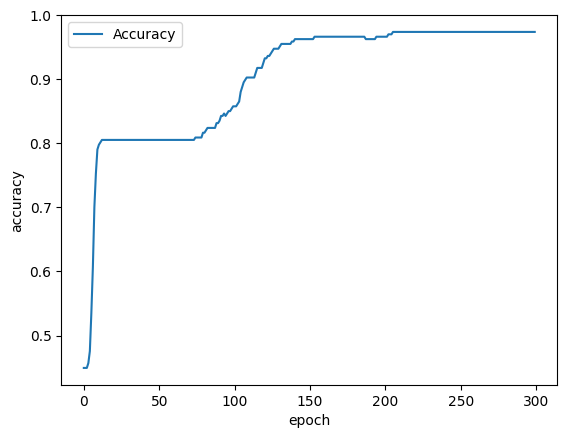

Accuracy: 0.99


In [69]:
result = experiment(tf.math.tanh, train_batches, test_batches)
result.history.draw()
print(f"Accuracy: {result.accuracy:0.2f}")

## sigmoid

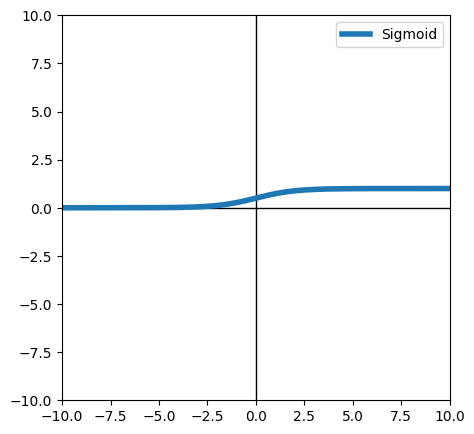

In [81]:
preview(tf.math.sigmoid, "Sigmoid")

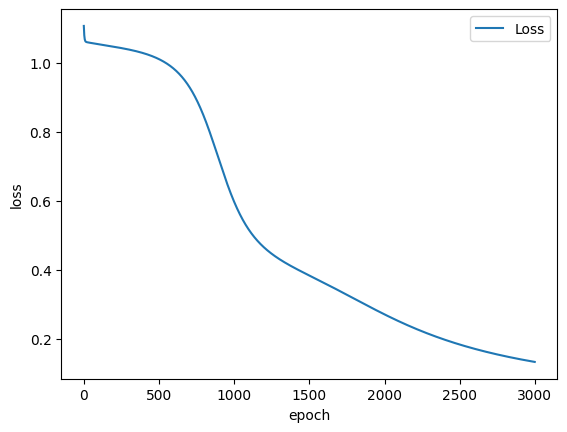

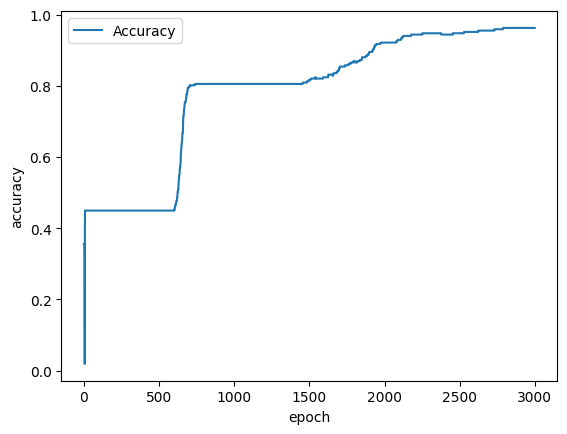

Accuracy: 0.97


In [75]:
result = experiment(tf.math.sigmoid, train_batches, test_batches, epochs=3000)
result.history.draw()
print(f"Accuracy: {result.accuracy:0.2f}")

## gelu

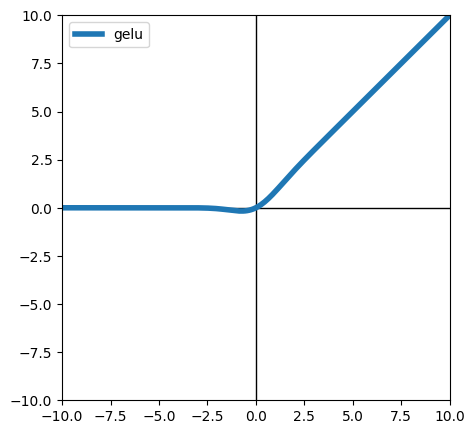

In [82]:
preview(tf.nn.gelu, "gelu")

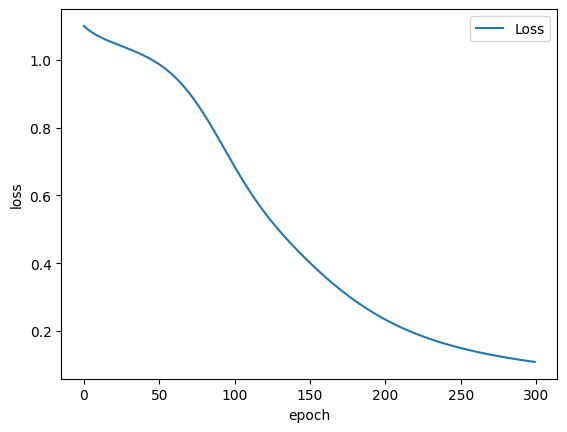

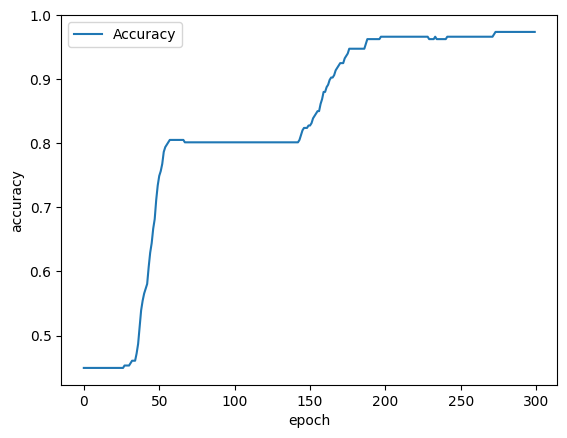

Accuracy: 0.97


In [37]:
result = experiment(tf.nn.gelu, train_batches, test_batches)
result.history.draw()
print(f"Accuracy: {result.accuracy:0.2f}")

## Custom

Let's try a custom function:

$$ 
act = \begin{cases}
    e^x &\text{if x < 0,} \\
    x &\text{otherwise}
\end{cases}
$$


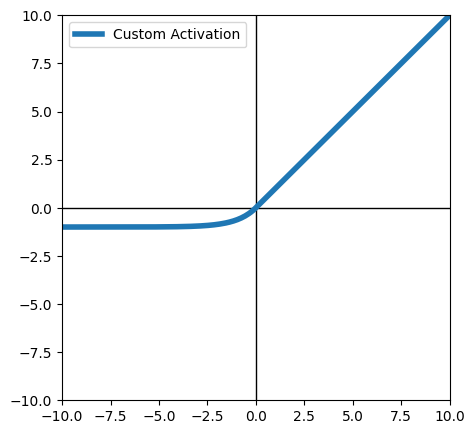

In [84]:
@tf.function
def custom_act(x):
    neg = x < 0
    return tf.cast(neg, x.dtype)*tf.exp(x) + tf.cast(~neg, x.dtype)*(x + 1) - 1

preview(custom_act, "Custom Activation")

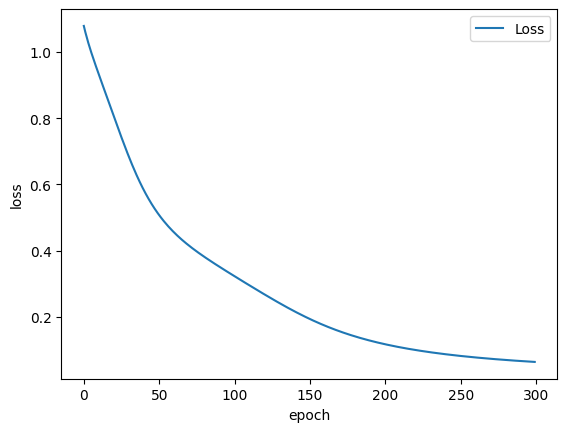

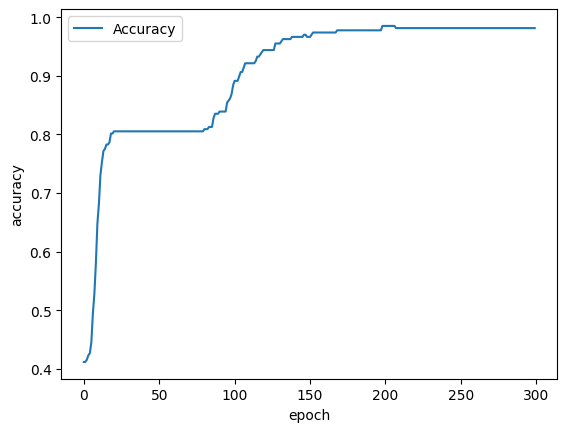

Accuracy: 0.99


In [45]:
result = experiment(custom_act, train_batches, test_batches)
result.history.draw()
print(f"Accuracy: {result.accuracy:0.2f}")

## Discussion

Well, on this simplistic task, I don't see any significant advantage of any activation function over the others. The $tanh(x)$ performs a little batter, but overall all activation function are very good (~99% accuracy). 

The only exception is $sigmoid(x)$ which performs very poorly. Why? Most likely it is not possible to fit the data using this activation function (the model is not flexible enough). Other, less likely explanation is that with `sigmoid` there are some problems in learning the training set. (**UPD**: After a bit of experimentation, I've found out, that `sigmoid` also achieves a high accuracy (~0.97), but it learns *10 times slower*!)

<img src="https://st2.depositphotos.com/1004472/9581/v/950/depositphotos_95814642-stock-illustration-sketch-of-thinking-man.jpg" width="200" />

### **So what's the difference?..**

...


# Historical Note

